<a href="https://colab.research.google.com/github/DmitrijLeontev/Dmitrij_Leontev/blob/main/%D1%81%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B8%20/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%B2%D0%B5%D0%B4%D1%83%D1%89%D0%B8%D0%B9_%D0%9A%D0%9F_%D0%9D%D0%B0_%D0%B7%D0%B0%D0%BA%D0%B0%D1%82%D0%B5/cod_neirovedushii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Целью данного проекта является разработка и интеграция искусственного интеллекта (ИИ) на базе ChatGPT для участия в телевизионной программе "На Закате" в роли ведущего. ИИ должен быть способен вести беседу с настоящими ведущими и отвечать на их вопросы, создавая естественную и непринужденную атмосферу для зрителей. Выведите гистограммы распределения длин чанков. Получите ответы нейро-ведущего на представленной БЗ(вводный документ)+ самаризированный диалог.

Тест проведем на основе русской сказки Колобок:-) Cсылк на ДБ: "https://docs.google.com/document/d/1bFBdxhVVVGzPvMp0YcunAi_8LGxJYr34z3a_kmL6o4Q/edit?usp=sharing"

In [ ]:
!pip install faiss-cpu langchain==0.0.271 openai tiktoken cohere

In [ ]:
!pip install openai==0.28.0

In [ ]:
import os
import getpass
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
import re
import requests
import openai
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import MarkdownHeaderTextSplitter
import matplotlib.pyplot as plt
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage
import tiktoken
from langchain.docstore.document import Document
openai_key = getpass.getpass("OpenAI API Key:")
os.environ["OPENAI_API_KEY"] = openai_key
openai.api_key = openai_key

OpenAI API Key:··········


In [ ]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [ ]:
# База знаний, которая будет подаваться в langChain
database= load_document_text('https://docs.google.com/document/d/1bFBdxhVVVGzPvMp0YcunAi_8LGxJYr34z3a_kmL6o4Q/edit?usp=sharing')   # заполните необходимым значением, база данных

In [ ]:
database[:1000]

'\ufeffЖили-были старик со старухой. Однажды просит старик:\r\n— Испеки, старуха, колобок.\r\n— Из чего испечь-то? Муки нет.\r\n— Эх, старуха! По коробу поскреби, по сусеку помети; авось муки и наберется.\r\nСтаруха по коробу поскребла, по сусеку помела, и набралось муки две пригоршни. Замесила на сметане, пожарила в масле и положила на окошечко остудить.\r\nКолобок полежал-полежал, да вдруг и покатился — с окна на лавку, с лавки на пол, по полу да к дверям, перепрыгнул через порог в сени, из сеней на крыльцо, с крыльца на двор, со двора за ворота, дальше и дальше.\r\nКатится колобок по дороге, а навстречу ему заяц:\r\n— Колобок, колобок! Я тебя съем!\r\n— Не ешь меня, косой зайчик! Я тебе песенку спою, — сказал колобок и запел:\r\nЯ по коробу скребен,\r\nПо сусеку метен,\r\nНа сметане мешон\r\nДа в масле пряжон,\r\nНа окошке стужон;\r\nЯ от дедушки ушел,\r\nЯ от бабушки ушел,\r\nОт тебя, зайца, не хитро уйти!\r\nИ покатился себе дальше; только заяц его и видел!..\r\nКатится колобок, а

In [ ]:
# предобработаем текст таким образом, чтобы его можно было бы поделить на чанки при помощи MarkdownHeaderTextSplitter
def text_to_markdown(text):
    # Добавляем заголовок 1 уровня на основе римских чисел (без переноса строки)
    # и дублируем его строчкой ниже - иначе эта информация перенесется в метаданные, а порой она бывает полезной.
    def replace_header1(match):
        return f"# {match.group(2)}\n{match.group(2)}"
    '''Далее используем функцию re.sub из модуля регулярных выражений re для замены подстрок в строке text.
    Шаблон регулярного выражения (I{1,3}|IV|V)\. (.+) ищет римские числа от I до V в начале строки, за которыми следует точка и пробел.
    Функция replace_header1 вызывается для каждого совпадения, и ее возвращаемое значение используется для замены найденной подстроки.
    Флаг re.M позволяет ^ соответствовать началу каждой строки, а не только началу всего текста.'''
    text = re.sub(r'^(I{1,3}|IV|V)\. (.+)', replace_header1, text, flags=re.M)

    # Добавляем текст, выделенный жирным шрифтом (он заключен между *)
    # и дублируем его строчкой ниже
    def replace_header2(match):
        return f"## {match.group(1)}\n{match.group(1)}"

    text = re.sub(r'\*([^\*]+)\*', replace_header2, text)

    return text

In [ ]:
markdown = text_to_markdown(database)                 # заполните необходимым значением
print(markdown[:5000])

﻿Жили-были старик со старухой. Однажды просит старик:
— Испеки, старуха, колобок.
— Из чего испечь-то? Муки нет.
— Эх, старуха! По коробу поскреби, по сусеку помети; авось муки и наберется.
Старуха по коробу поскребла, по сусеку помела, и набралось муки две пригоршни. Замесила на сметане, пожарила в масле и положила на окошечко остудить.
Колобок полежал-полежал, да вдруг и покатился — с окна на лавку, с лавки на пол, по полу да к дверям, перепрыгнул через порог в сени, из сеней на крыльцо, с крыльца на двор, со двора за ворота, дальше и дальше.
Катится колобок по дороге, а навстречу ему заяц:
— Колобок, колобок! Я тебя съем!
— Не ешь меня, косой зайчик! Я тебе песенку спою, — сказал колобок и запел:
Я по коробу скребен,
По сусеку метен,
На сметане мешон
Да в масле пряжон,
На окошке стужон;
Я от дедушки ушел,
Я от бабушки ушел,
От тебя, зайца, не хитро уйти!
И покатился себе дальше; только заяц его и видел!..
Катится колобок, а навстречу ему волк:
— Колобок, колобок! Я тебя съем!
— Не е

In [ ]:
# Инструкция в system
system = load_document_text('https://docs.google.com/document/d/1vmlu1DXhg48ltJBf9lvCraUi8TWNQ-gBmh1tRKv1eXQ/edit?usp=sharing') # заполните параметр ссылкой на составленный вами промпт. Не забудьте открыть доступ

In [ ]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=20, alpha=0.5, label='Fragments')
    plt.title('Distribution of Fragment Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )

    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]

    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return source_chunks

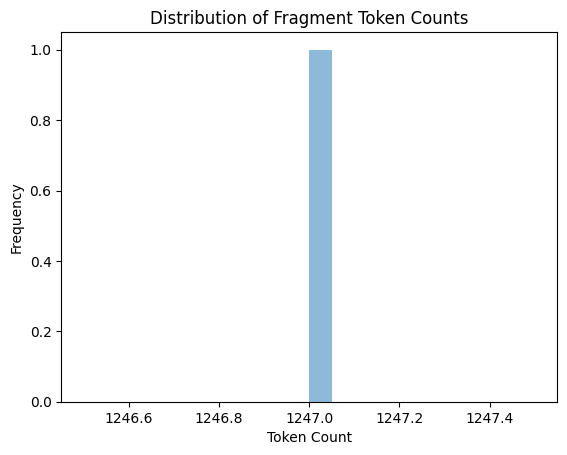

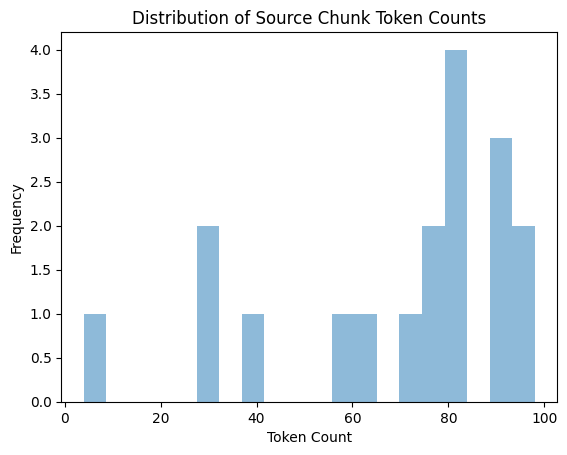

Общее количество чанков:  18
Первый чанк  page_content='\ufeffЖили-были старик со старухой. Однажды просит старик:\n— Испеки, старуха, колобок.\n— Из чего испечь-то? Муки нет.' metadata={}


In [ ]:
source_chunks = split_text(database, 100)                          # заполните необходимыми значениями
print("Общее количество чанков: ",len(source_chunks))
print("Первый чанк ", source_chunks[0])

In [ ]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(source_chunks, embeddings)

In [ ]:
def insert_newlines(text: str, max_len: int = 170) -> str:
    """
    Функция разбивает длинный текст на строки определенной максимальной длины.
    """
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return "\n".join(lines)

In [ ]:
def answer_index(system, topic, search_index, temp=0, verbose=0) -> str:
    """
    Функция возвращает ответ модели на основе заданной темы.
    """
    # находим наиболее релевантные вопросу пользователя чанки:
    docs = search_index.similarity_search(topic, k=4)

    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))

    # если параметр verbose=1, то выводим релевантные чанки
    if verbose:
        print('message_content :\n', message_content)

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Документ с информацией для ответа пользователю: {message_content}\n\nВопрос пользователя: \n{topic}"}
    ]

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=temp
    )

    return insert_newlines(completion.choices[0].message.content)

In [ ]:
def summarize_questions(dialog):
    """
    Функция возвращает саммаризированный текст диалога.
    """
    messages = [
        {"role": "system", "content": "Ты - нейро-саммаризатор. Твоя задача - саммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в саммаризированном диалоге"},
        {"role": "user", "content": "Саммаризируй следующий диалог консультанта и пользователя: " + " ".join(dialog)}
    ]

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",     # используем gpt3.5 для более точной саммаризации
        messages=messages,
        temperature=0,          # Используем более низкую температуру для более определенной суммаризации
    )

    return completion.choices[0].message.content

In [ ]:
def answer_user_question_dialog(system, db, user_question, question_history):
    """
    Функция возвращает ответ на вопрос пользователя.
    """
    summarized_history = ""
    # Если в истории более одного вопроса, применяем суммаризацию
    if len(question_history) > 0:
        summarized_history = "Вот краткий обзор предыдущего диалога: " + summarize_questions([q + ' ' + (a if a else '') for q, a in question_history])

    # Добавляем явное разделение между историей диалога и текущим вопросом
    input_text = summarized_history + "\n\nТекущий вопрос: " + user_question

    # Извлекаем наиболее похожие отрезки текста из базы знаний и получение ответа модели
    answer_text = answer_index(system, input_text, db)

    # Добавляем вопрос пользователя и ответ системы в историю
    question_history.append((user_question, answer_text if answer_text else ''))

    # Выводим саммаризированный текст, который видит модель
    if summarized_history:
        print('****************************')
        print(insert_newlines(summarized_history))
        print('****************************')

    return insert_newlines(answer_text)

In [ ]:
def run_dialog(system_doc_url, knowledge_base_url):
    """
    Функция запускает диалог между пользователем и нейро-консультантом.
    """
    #список кортежей, где каждый кортеж содержит пару вопрос-ответ, для отслеживания истории вопросов и ответов во время сессии диалога.
    question_history = []
    while True:
        user_question = input('Пользователь: ')
        if user_question.lower() == 'stop':
            break
        answer = answer_user_question_dialog(system_doc_url, knowledge_base_url, user_question, question_history)
        print('Консультант:', answer)

    return

In [ ]:
# проверьте работу нейро-консультанта на нескольких самостоятельно сгенерированных вопросах. Проверьте, что соблюдаются инструкции и поддерживается диалог
run_dialog(system, db)

Пользователь: Кто испек колобка?
Консультант:  Старик попросил старуху испечь колобок.
Пользователь: А от зайца колобок ушел?
****************************
 Вот краткий обзор предыдущего диалога: Пользователь спросил, кто испек колобка, на что консультант ответил, что старик попросил старуху испечь колобок.
****************************
Консультант:  Да, от зайца колобок ушел.
Пользователь: Медведь Колобка скушал?
****************************
 Вот краткий обзор предыдущего диалога: Пользователь спросил, кто испек колобка. Консультант ответил, что старик попросил старуху испечь колобок. Пользователь уточнил,
 ушел ли колобок от зайца. Консультант подтвердил, что колобок ушел от зайца.
****************************
Консультант:  Нет, медведь не скушал Колобка.
Пользователь: А кто скушал, волк?
****************************
 Вот краткий обзор предыдущего диалога: Пользователь и консультант обсуждают историю о колобке. Старик попросил старуху испечь колобок. Колобок ушел от зайца, но медведь
 